In [1]:
import os
import cv2
import json
import numpy as np
from scipy.ndimage import distance_transform_edt as distance
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial

# ==========================================
# [설정] 경로 및 클래스 정의
# ==========================================
IMAGE_ROOT = "../data/train/DCM"
LABEL_ROOT = "../data/train/outputs_json"
SAVE_ROOT = "../data/train/dist_maps_boundary"  # 경계 데이터 저장 경로

# 경계 폭 설정 (핵심 파라미터!)
BOUNDARY_WIDTH = 20  # 경계로부터 ±20 픽셀만 저장

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

# ==========================================
# [핵심] 경계만 저장하는 함수 (병렬 처리용)
# ==========================================
def process_single_image(png_rel_path, image_root, label_root, save_root, 
                        class2ind, num_classes, boundary_width):
    """단일 이미지의 경계 Distance Map을 생성하는 함수"""
    
    json_rel_path = png_rel_path.replace(".png", ".json")
    
    image_path = os.path.join(image_root, png_rel_path)
    label_path = os.path.join(label_root, json_rel_path)
    
    # .npz로 저장 (압축)
    save_rel_path = png_rel_path.replace(".png", ".npz")
    save_path = os.path.join(save_root, save_rel_path)
    
    # 이미 존재하면 스킵
    if os.path.exists(save_path):
        return f"Skip: {png_rel_path}"
    
    # 폴더 생성
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    try:
        # 이미지 크기만 확인
        image = cv2.imread(image_path)
        if image is None:
            return f"Error: Cannot read {png_rel_path}"
        h, w = image.shape[:2]
        
        # 라벨 생성
        label = np.zeros((h, w, num_classes), dtype=np.uint8)
        
        with open(label_path, "r") as f:
            annotations = json.load(f)["annotations"]
        
        for ann in annotations:
            c = ann["label"]
            class_ind = class2ind[c]
            points = np.array(ann["points"])
            
            class_label = np.zeros((h, w), dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        # 경계 데이터만 저장
        boundary_data = {}
        boundary_data['shape'] = np.array([h, w, num_classes], dtype=np.int32)
        
        total_saved_pixels = 0
        total_pixels = h * w * num_classes
        
        for c in range(num_classes):
            posmask = label[..., c].astype(bool)
            
            if not posmask.any():
                # 해당 클래스 없음 - 저장 안 함
                continue
            
            # Distance Map 계산
            negmask = ~posmask
            pos_dist = distance(posmask)
            neg_dist = distance(negmask)
            dist_map = neg_dist * negmask - (pos_dist - 1) * posmask
            
            # 경계 근처만 선택 (핵심!)
            # |distance| <= boundary_width인 픽셀만
            boundary_mask = np.abs(dist_map) <= boundary_width
            
            if boundary_mask.any():
                # 인덱스와 값 추출
                indices = np.where(boundary_mask)
                values = dist_map[boundary_mask]
                
                # 저장 (메모리 효율적으로)
                boundary_data[f'class_{c}'] = {
                    'y': indices[0].astype(np.uint16),  # Y 좌표
                    'x': indices[1].astype(np.uint16),  # X 좌표
                    'values': values.astype(np.float16) # Distance 값
                }
                
                total_saved_pixels += len(values)
        
        # 압축하여 저장
        np.savez_compressed(save_path, **boundary_data)
        
        # 통계 계산
        saved_size = os.path.getsize(save_path)
        original_size = h * w * num_classes * 4  # float32 기준
        compression_ratio = original_size / saved_size if saved_size > 0 else 0
        save_ratio = (total_saved_pixels / total_pixels * 100) if total_pixels > 0 else 0
        
        return (f"Success: {png_rel_path} | "
                f"Saved: {total_saved_pixels:,}/{total_pixels:,} ({save_ratio:.1f}%) | "
                f"Size: {saved_size/1024:.1f}KB | "
                f"Compression: {compression_ratio:.1f}x")
    
    except Exception as e:
        return f"Error: {png_rel_path} - {str(e)}"

# ==========================================
# [1] 파일 리스트 가져오기
# ==========================================
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

# JSON이 있는 이미지만 필터링
png_list = sorted([p for p in pngs if p.replace(".png", ".json") in jsons])

print(f"이미지 개수: {len(png_list)}")
print(f"경계 폭: ±{BOUNDARY_WIDTH} 픽셀")
print(f"저장 경로: {SAVE_ROOT}")

# ==========================================
# [2] 병렬 처리로 경계 Distance Map 생성
# ==========================================
# CPU 코어 수 설정
num_workers = max(1, os.cpu_count() - 2)
print(f"병렬 작업자 수: {num_workers}\n")

# partial로 고정 인자 바인딩
process_func = partial(
    process_single_image,
    image_root=IMAGE_ROOT,
    label_root=LABEL_ROOT,
    save_root=SAVE_ROOT,
    class2ind=CLASS2IND,
    num_classes=len(CLASSES),
    boundary_width=BOUNDARY_WIDTH
)

# 병렬 처리 실행
success_count = 0
error_count = 0
total_compression = []

with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(process_func, png_path): png_path 
               for png_path in png_list}
    
    # 진행률 표시
    for future in tqdm(as_completed(futures), total=len(png_list), 
                      desc="Generating Boundary Maps"):
        result = future.result()
        
        if result.startswith("Success"):
            success_count += 1
            # 압축률 추출
            if "Compression:" in result:
                try:
                    comp = float(result.split("Compression: ")[1].split("x")[0])
                    total_compression.append(comp)
                except:
                    pass
        elif result.startswith("Error"):
            error_count += 1
            print(f"\n{result}")

print("\n" + "="*70)
print("✅ 모든 경계 Distance Map 생성 완료!")
print("="*70)

# 최종 통계
print(f"\n📊 생성 결과:")
print(f"  - 성공: {success_count}개")
print(f"  - 실패: {error_count}개")

if total_compression:
    avg_compression = sum(total_compression) / len(total_compression)
    print(f"  - 평균 압축률: {avg_compression:.1f}x")

# 전체 용량 계산
if os.path.exists(SAVE_ROOT):
    total_size = 0
    file_count = 0
    for root, dirs, files in os.walk(SAVE_ROOT):
        for file in files:
            if file.endswith('.npz'):
                total_size += os.path.getsize(os.path.join(root, file))
                file_count += 1
    
    if file_count > 0:
        print(f"\n💾 저장 용량:")
        print(f"  - 총 용량: {total_size / 1024**3:.2f} GB")
        print(f"  - 평균 용량: {total_size / file_count / 1024:.1f} KB/장")
        
        # 원본 대비 절약된 용량 추정
        if png_list:
            sample_img = cv2.imread(os.path.join(IMAGE_ROOT, png_list[0]))
            if sample_img is not None:
                h, w = sample_img.shape[:2]
                original_size_per_file = h * w * len(CLASSES) * 4  # float32
                estimated_original = original_size_per_file * file_count
                saved_space = estimated_original - total_size
                print(f"  - 절약된 용량: {saved_space / 1024**3:.2f} GB ({saved_space/estimated_original*100:.1f}%)")

print("\n💡 사용 방법:")
print("  dist_map = np.load('path/to/file.npz')")
print("  shape = dist_map['shape']  # [H, W, C]")
print("  class_0_data = dist_map['class_0'].item()")
print("  y, x, values = class_0_data['y'], class_0_data['x'], class_0_data['values']")

이미지 개수: 800
경계 폭: ±20 픽셀
저장 경로: ../data/train/dist_maps_boundary
병렬 작업자 수: 6



Generating Boundary Maps:   0%|          | 0/800 [00:00<?, ?it/s]


✅ 모든 경계 Distance Map 생성 완료!

📊 생성 결과:
  - 성공: 800개
  - 실패: 0개
  - 평균 압축률: 1885.3x

💾 저장 용량:
  - 총 용량: 0.19 GB
  - 평균 용량: 252.8 KB/장
  - 절약된 용량: 362.31 GB (99.9%)

💡 사용 방법:
  dist_map = np.load('path/to/file.npz')
  shape = dist_map['shape']  # [H, W, C]
  class_0_data = dist_map['class_0'].item()
  y, x, values = class_0_data['y'], class_0_data['x'], class_0_data['values']


📂 파일 로드 중: image1661317775801.npz
🎨 Combined View 생성 중...


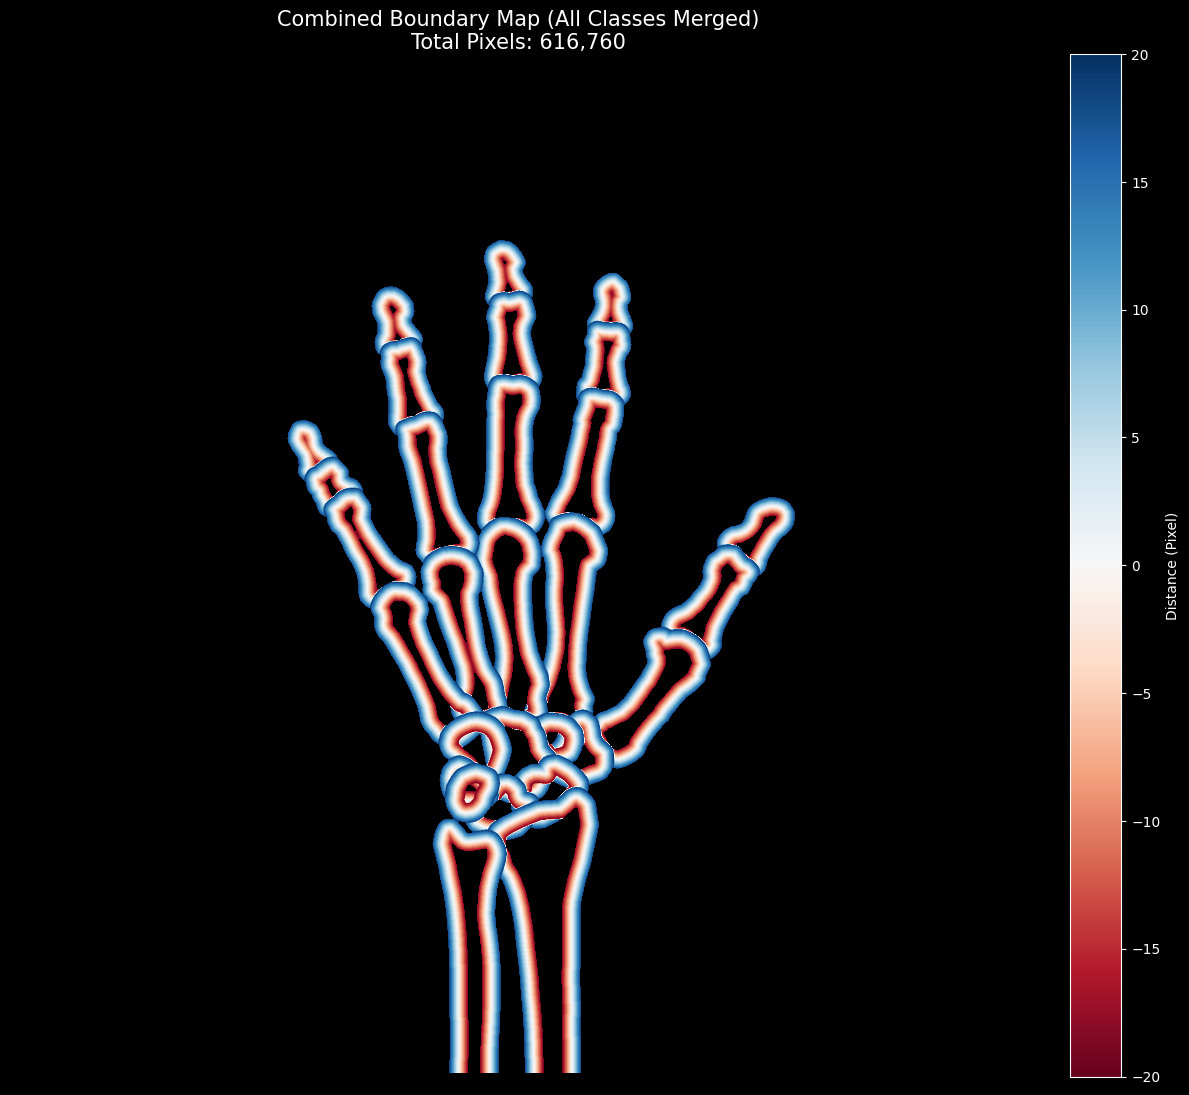

🎨 Grid View 생성 중...


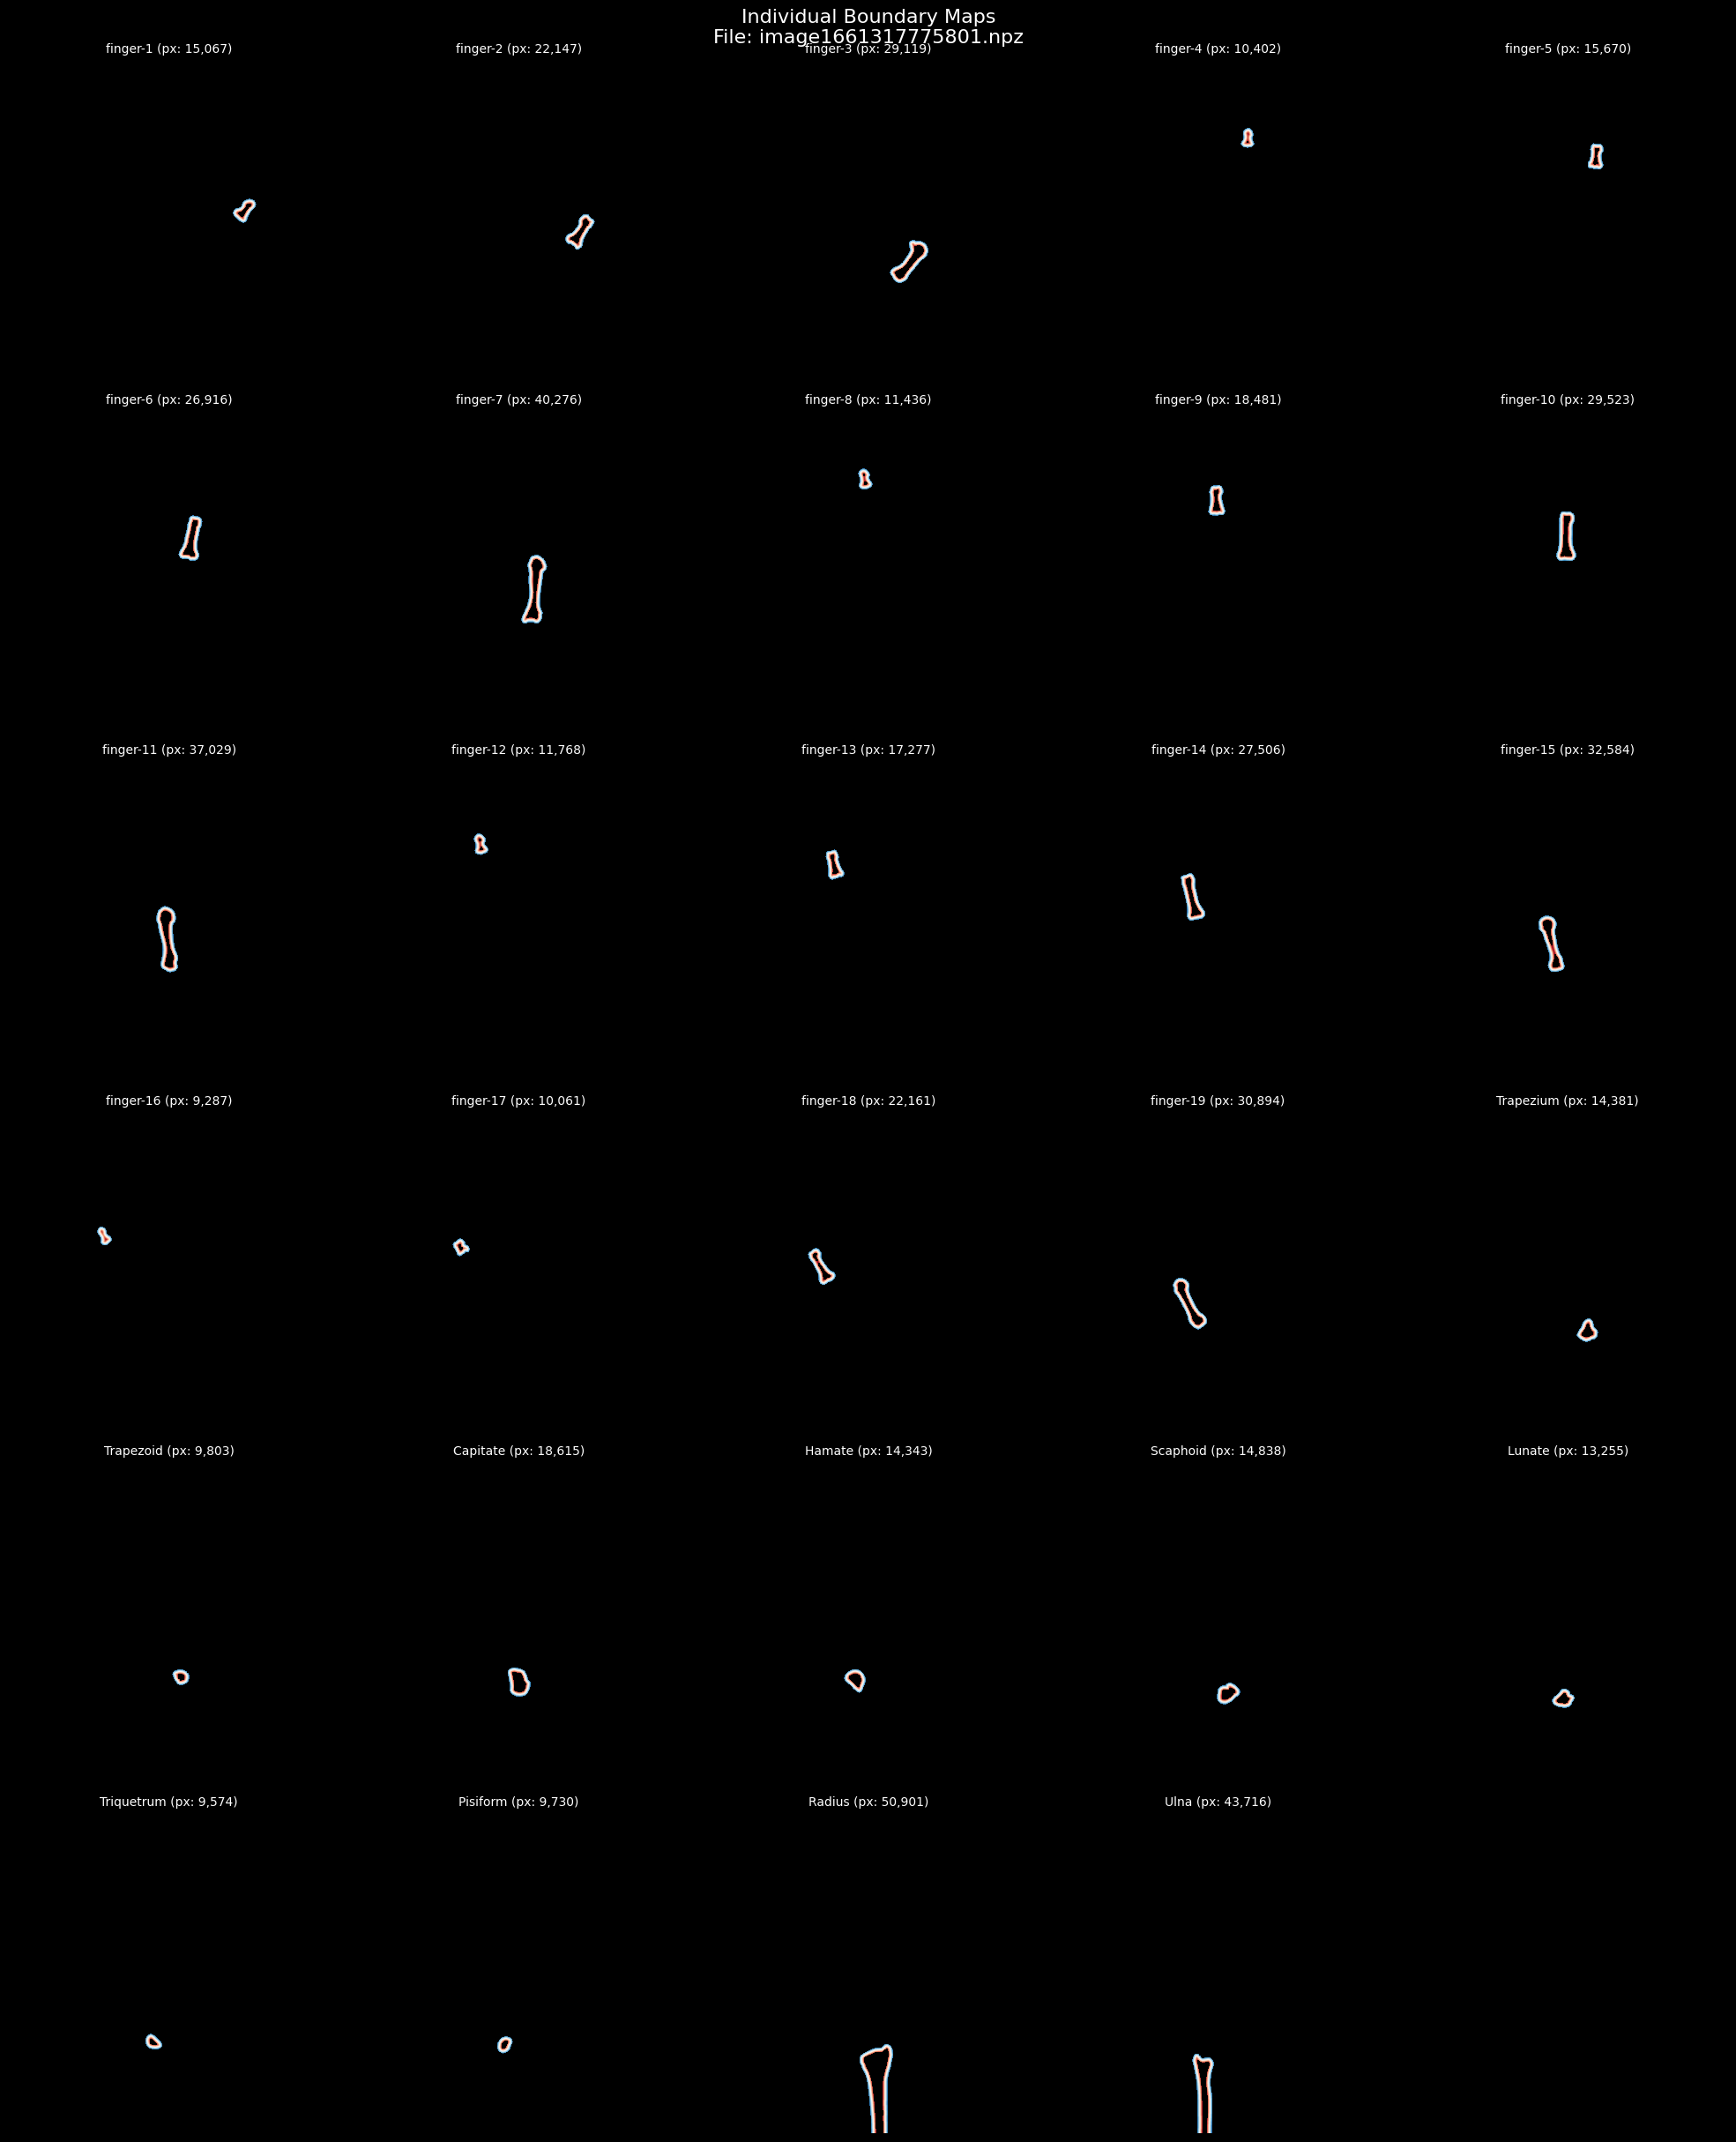

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math

# ==========================================
# [설정] 경로 및 클래스
# ==========================================
SAVE_ROOT = "../data/train/dist_maps_boundary"
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

# ==========================================
# [함수 1] 모든 클래스 통합 시각화 (추가된 기능)
# ==========================================
def visualize_combined_view(data, h, w):
    """모든 클래스의 경계 데이터를 하나의 맵에 합쳐서 시각화합니다."""
    
    # 1. 빈 캔버스 생성 (NaN으로 초기화)
    combined_map = np.full((h, w), np.nan, dtype=np.float32)
    total_pixels = 0

    # 2. 모든 클래스 데이터를 순회하며 캔버스에 덮어쓰기
    for i, class_name in enumerate(CLASSES):
        key = f'class_{i}'
        if key in data:
            class_data = data[key].item()
            y_idxs = class_data['y']
            x_idxs = class_data['x']
            values = class_data['values']
            
            # 캔버스에 해당 클래스 값 입력
            # (겹치는 부분은 나중 클래스가 덮어쓰지만, 경계는 보통 겹치지 않으므로 무방)
            combined_map[y_idxs, x_idxs] = values
            total_pixels += len(values)

    # 3. 시각화
    plt.figure(figsize=(12, 12))
    plt.style.use('dark_background')
    
    img = plt.imshow(combined_map, cmap='RdBu', vmin=-20, vmax=20)
    plt.colorbar(img, label='Distance (Pixel)', fraction=0.046, pad=0.04)
    
    plt.title(f"Combined Boundary Map (All Classes Merged)\nTotal Pixels: {total_pixels:,}", fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# [함수 2] 클래스별 그리드 시각화 (기존 기능)
# ==========================================
def visualize_grid_view(data, h, w, filename):
    """각 클래스별 경계 맵을 그리드 형태로 시각화합니다."""
    
    # 그리드 설정
    cols = 5
    rows = math.ceil(len(CLASSES) / cols)
    
    plt.figure(figsize=(20, 4 * rows))
    plt.style.use('dark_background')

    for i, class_name in enumerate(CLASSES):
        ax = plt.subplot(rows, cols, i + 1)
        key = f'class_{i}'
        
        if key in data:
            class_data = data[key].item()
            y_idxs = class_data['y']
            x_idxs = class_data['x']
            values = class_data['values']
            
            dist_map = np.full((h, w), np.nan, dtype=np.float32)
            dist_map[y_idxs, x_idxs] = values
            
            ax.imshow(dist_map, cmap='RdBu', vmin=-20, vmax=20)
            ax.set_title(f"{class_name} (px: {len(values):,})", fontsize=10, color='white')
        else:
            dist_map = np.zeros((h, w), dtype=np.float32)
            ax.imshow(dist_map, cmap='gray', vmin=0, vmax=1)
            ax.text(w//2, h//2, "No Data", color='red', ha='center', va='center', fontsize=12, fontweight='bold')
            ax.set_title(f"{class_name}", fontsize=10, color='gray')

        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f"Individual Boundary Maps\nFile: {filename}", fontsize=16, y=1.01)
    plt.show()

# ==========================================
# [실행] 메인 로직
# ==========================================
def main_visualization():
    # 1. 파일 찾기
    sample_path = None
    for root, dirs, files in os.walk(SAVE_ROOT):
        for file in files:
            if file.endswith('.npz'):
                sample_path = os.path.join(root, file)
                break
        if sample_path:
            break

    if not sample_path:
        print(f"❌ '{SAVE_ROOT}' 경로에서 .npz 파일을 찾을 수 없습니다.")
        return

    print(f"📂 파일 로드 중: {os.path.basename(sample_path)}")

    # 2. 데이터 로드 (한 번만 수행하여 공유)
    try:
        data = np.load(sample_path, allow_pickle=True)
        h, w, c = data['shape']
    except Exception as e:
        print(f"❌ 데이터 로드 오류: {e}")
        return

    # 3. 통합 뷰 실행 (크게 보기)
    print("🎨 Combined View 생성 중...")
    visualize_combined_view(data, h, w)

    # 4. 개별 뷰 실행 (상세 보기)
    print("🎨 Grid View 생성 중...")
    visualize_grid_view(data, h, w, os.path.basename(sample_path))

if __name__ == "__main__":
    main_visualization()